In [1]:
from cdl_helper import read_in_all_matches

df = read_in_all_matches()
df.sample(4)

,gameMap,gameMode,id,programId,firstName,lastName,alias,headshot,socialNetworkHandles,averageSpeed,...,matchGame.gameMap.publishDetails.time,matchGame.gameMap.publishDetails.user,matchGameResult.hostGameScore,matchGameResult.guestGameScore,matchGameResult.winnerTeamId,matchGameResult.loserTeamId,event,setting,totalHeadshots,totalTiersCaptured
31,Breenbergh Hotel,CDL Hardpoint,229,2,Zachary,Jordan,Drazah,https://www.callofduty.com/content/dam/activis...,[],181.179108,...,2022-12-05T10:02:00.334Z,blte5475d8d4c1a4efe,220.0,250.0,69.0,138.0,M2Qual,online,NaN,NaN
29,Al Bagra Fortress,CDL Hardpoint,217,2,Kaden,Stockdale,Exceed,https://www.callofduty.com/content/dam/activis...,"[{'socialNetworkType': 'TWITTER', 'handle': 'h...",220.083176,...,2022-12-05T10:03:45.339Z,blte5475d8d4c1a4efe,250.0,89.0,16.0,11.0,M3Event,lan,NaN,NaN
2,Zarqwa Hydroelectric,CDL Hardpoint,61,2,Trei,Morris,Zer0,https://www.callofduty.com/content/dam/activis...,"[{'socialNetworkType': 'TWITTER', 'handle': 'h...",178.985138,...,2022-12-05T10:02:29.302Z,blte5475d8d4c1a4efe,120.0,250.0,11.0,10.0,M1Qual,online,NaN,NaN
18,Al Bagra Fortress,CDL Control,225,2,Makenzie,Kelley,Mack,https://www.callofduty.com/content/dam/activis...,[],191.054092,...,2022-12-05T10:03:45.339Z,blte5475d8d4c1a4efe,1.0,3.0,10.0,16.0,M3Qual,online,NaN,NaN


In [2]:
test = df[df['event']=='M3Event']

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cdl_helper import CDL_PALETTE as pal
pal

{'NY': 'yellow',
 'LV': 'orange',
 'BOS': '#0bf52b',
 'FLA': 'cyan',
 'MIN': 'purple',
 'TOR': '#f40afe',
 'ATL': '#f84c4c',
 'TX': 'green',
 'LAT': 'red',
 'LAG': '#7a0265',
 'SEA': 'blue',
 'LDN': '#800020'}

In [4]:
df['matchDesc'] = [f"{player} vs {op}\n({event})" for player, op, event in zip(df['alias'], df['oppo_abbrev'], df['event'])]
df['matchDesc'][:3]

0    Cellium vs BOS\n(M1Qual)
1    Methodz vs ATL\n(M1Qual)
2       Simp vs BOS\n(M1Qual)
Name: matchDesc, dtype: object

<AxesSubplot:xlabel='matchDesc'>

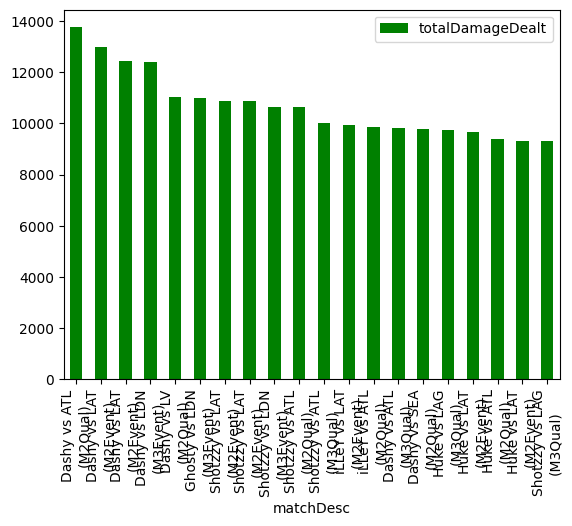

In [5]:
refined = df[['matchDesc', 'abbrev', 'totalDamageDealt', 'matchGame.matchId']]
damage_df = refined.groupby(['matchDesc', 'abbrev', 'matchGame.matchId']).sum().reset_index()
tx_dam = damage_df[damage_df['abbrev']=='TX'].sort_values(by='totalDamageDealt', ascending=False).reset_index().drop('index', axis=1)
tx_dam[['matchDesc', 'totalDamageDealt']].iloc[0:20].set_index('matchDesc').plot(kind="bar", color='green')

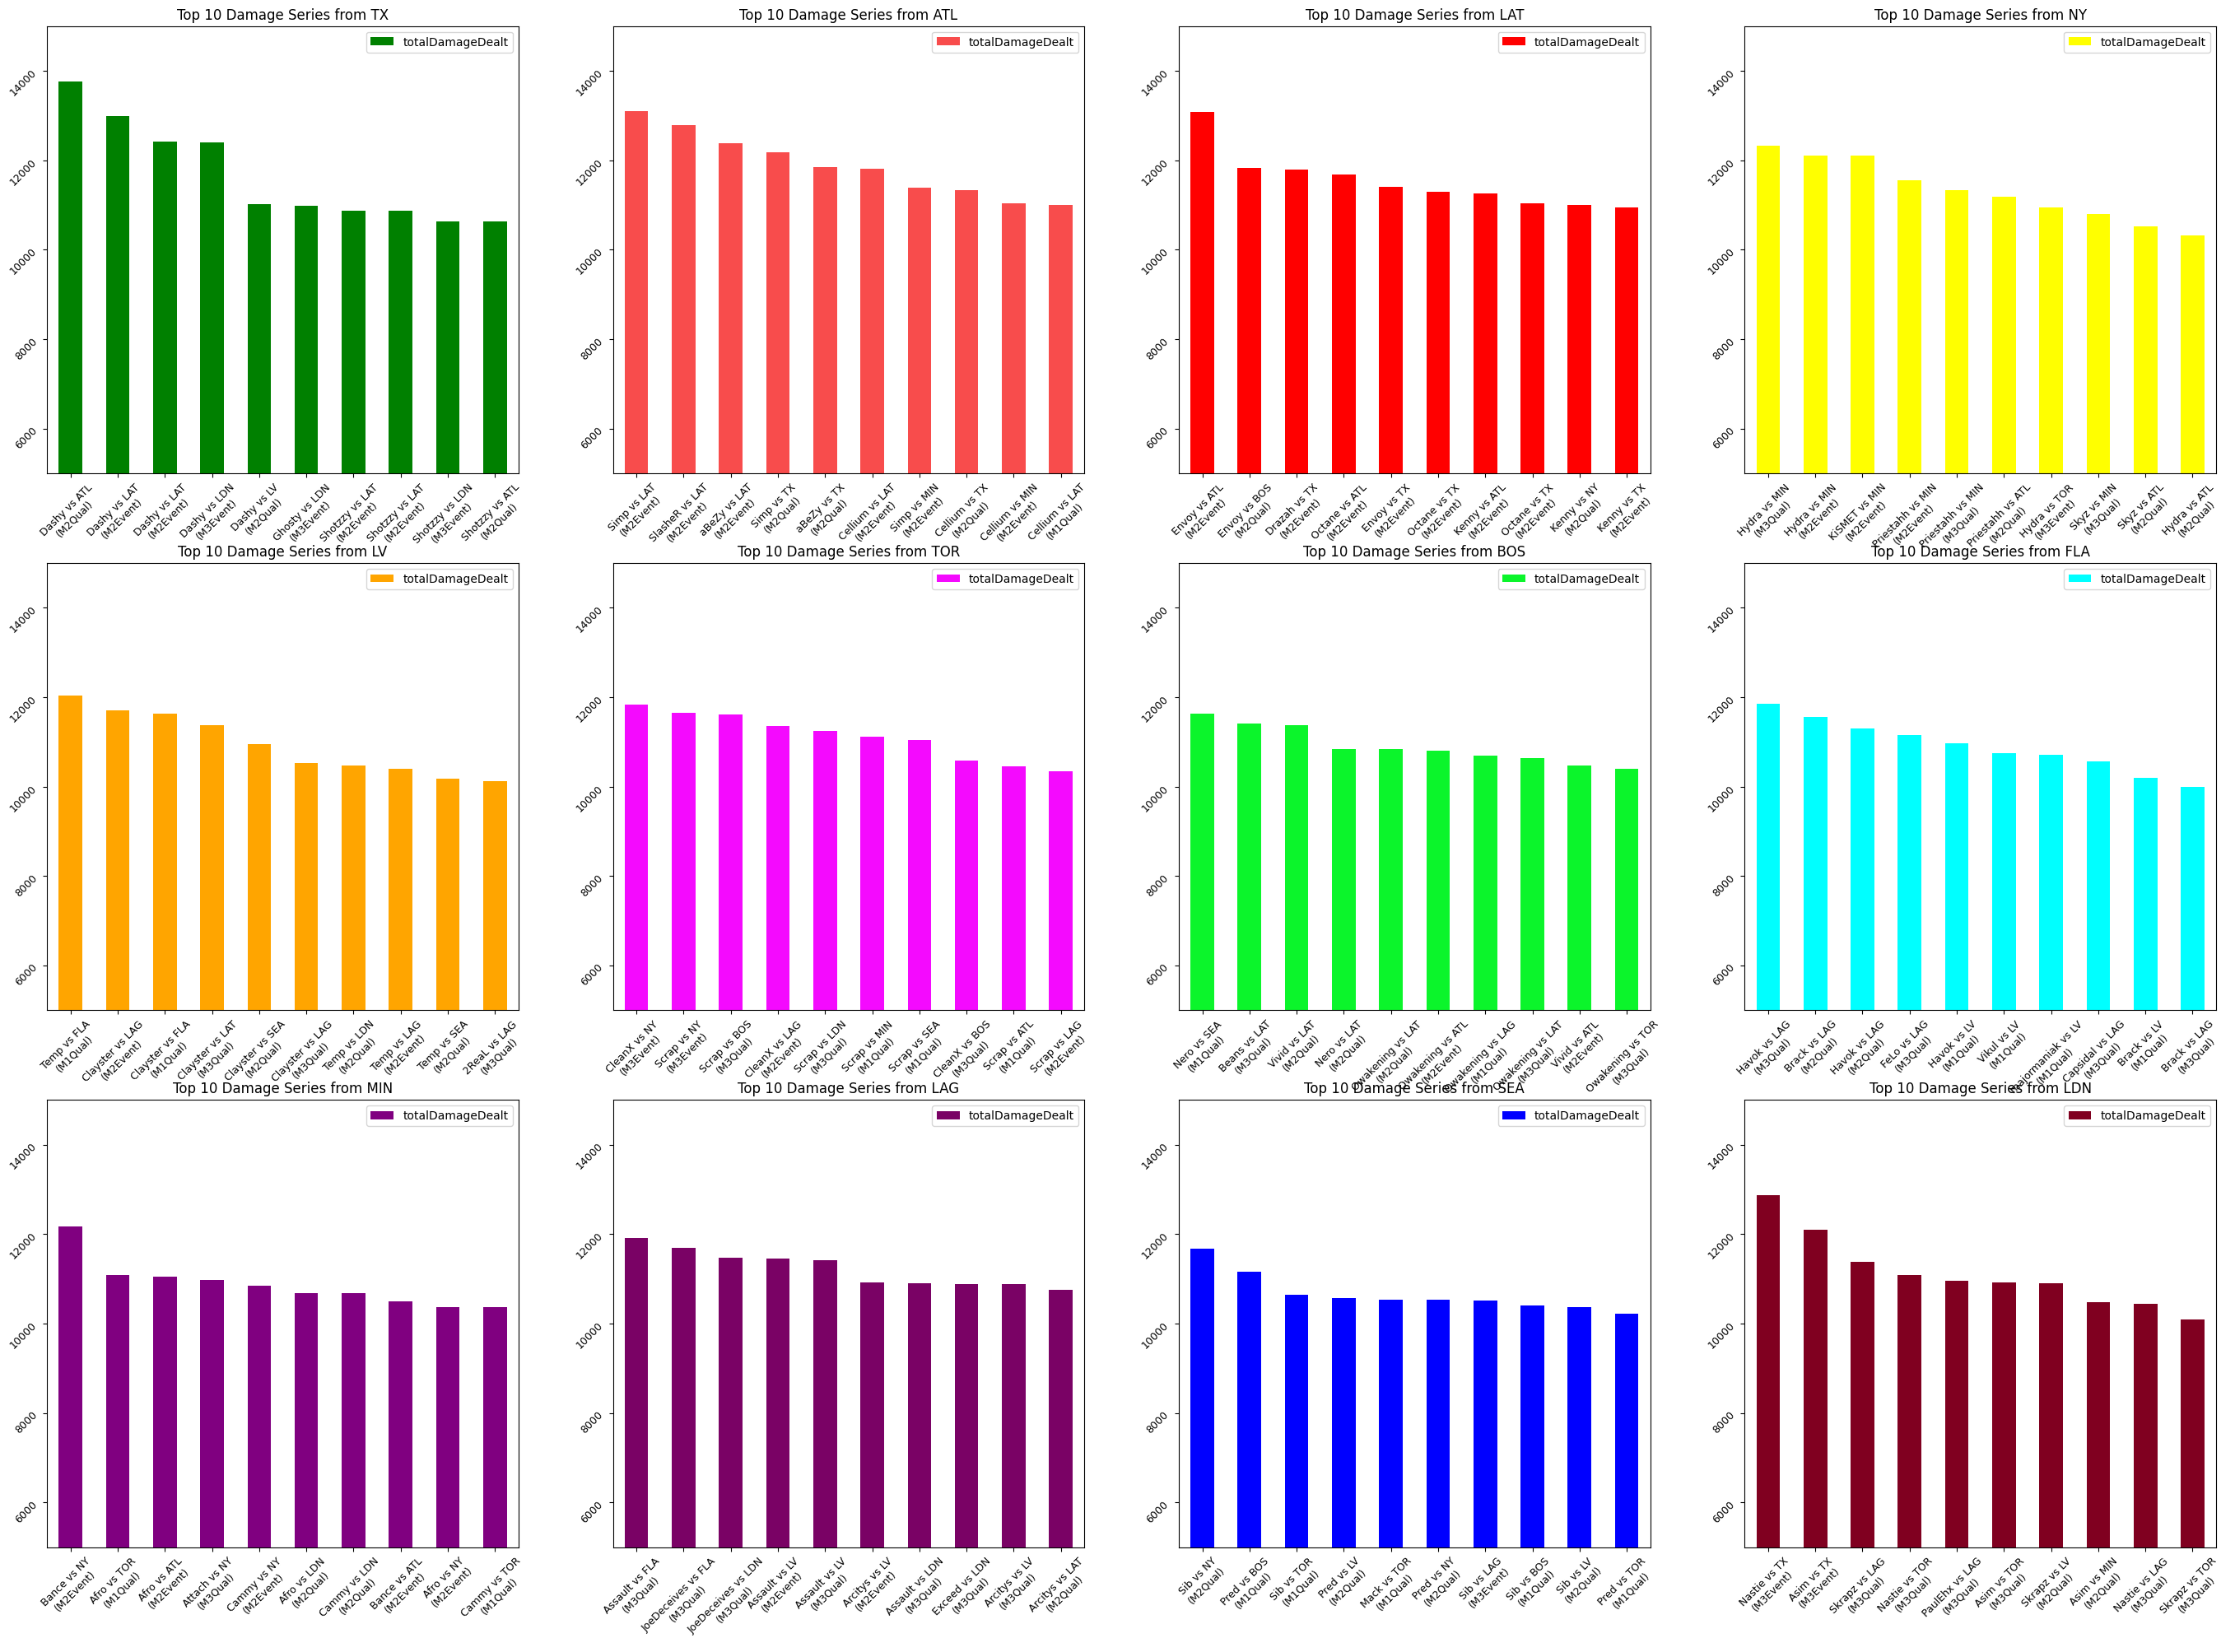

In [6]:

fig = plt.figure(figsize=(34, 24))
axes = [((x for i in range(4)) for i in range(3))] 
axes = fig.subplots(ncols=4, nrows=3)

damage_df = damage_df.sort_values('totalDamageDealt', ascending=False)
teams = (('TX', 'ATL', 'LAT', 'NY'), ('LV', 'TOR', 'BOS', 'FLA'), ('MIN', 'LAG', 'SEA', 'LDN'))
for i in range(len(teams)):
    for j in range(4):
        refined_df = damage_df[damage_df['abbrev']==teams[i][j]]
        refined.sort_values('totalDamageDealt', ascending=False)
        refined_df[['matchDesc', 'totalDamageDealt']].iloc[0:10].set_index('matchDesc').plot(kind='bar', ax=axes[i][j], color=pal[teams[i][j]])
        axes[i][j].set_title(f"Top 10 Damage Series from {teams[i][j]}")
        axes[i][j].tick_params(rotation=45, labelsize=9)
        axes[i][j].set(xlabel=None)
        axes[i][j].set_ylim(5000, 15000)

fig.savefig("top_10_dmg.png")
        



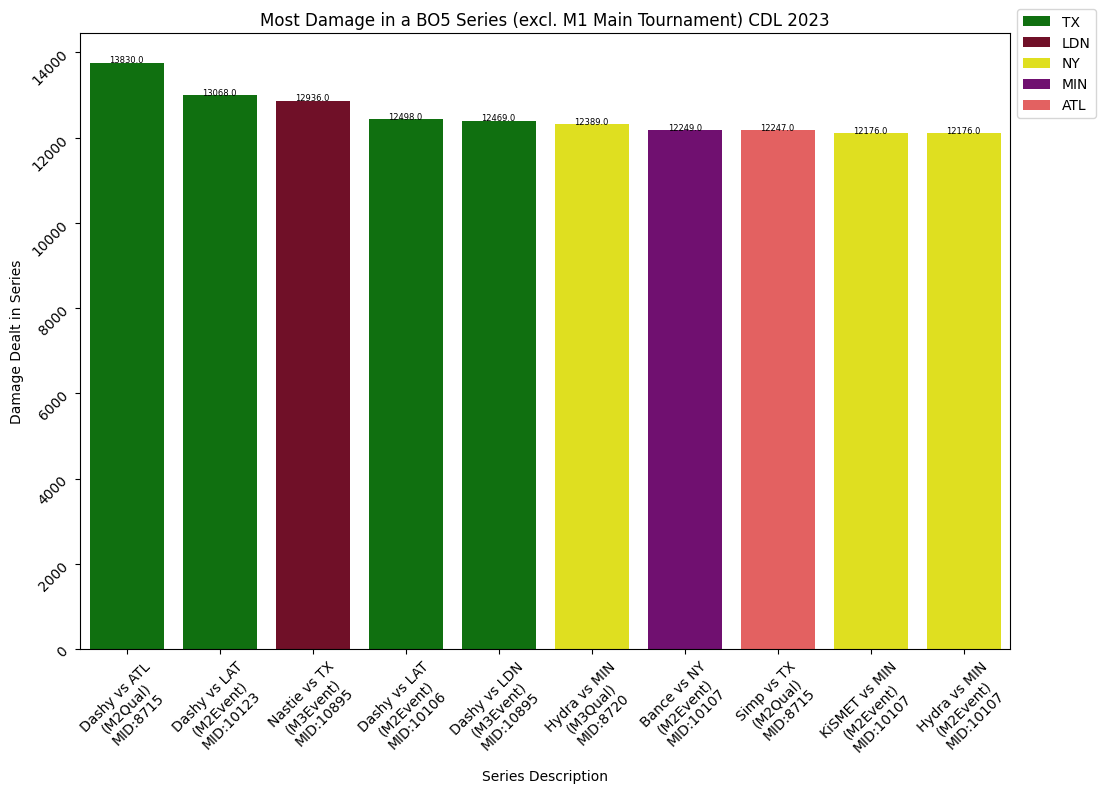

In [7]:
new_fig = plt.figure(figsize=(12, 8))
(ax1) = new_fig.subplots()
sorted_df = damage_df.sort_values('totalDamageDealt', ascending=False)
sorted_df['matchDesc'] = [f"{a}\nMID:{b}" for a, b in zip(sorted_df['matchDesc'], sorted_df['matchGame.matchId'])]
sorted_df = sorted_df[sorted_df['matchGame.matchId'] != 10113]
sns.barplot(data=sorted_df.iloc[0:10], x='matchDesc', y='totalDamageDealt', hue='abbrev', palette=pal, ax=ax1, dodge=False, errorbar=('ci', 0))
ax1.legend(bbox_to_anchor=(1, 1.05))
ax1.tick_params(rotation=45)
ax1.set_ylabel("Damage Dealt in Series")
ax1.set_xlabel("Series Description")
for x, y in zip(ax1.get_xticks(), sorted_df['totalDamageDealt']):
    ax1.text(x, y, s=y+70, horizontalalignment='center', fontsize=6)

ax1.set_title("Most Damage in a BO5 Series (excl. M1 Main Tournament) CDL 2023");
new_fig.savefig("dmg.png")